In [19]:
!pip install tqdm
!pip install numpy
!pip install gensim
!pip install pandas
!pip install seaborn
!pip install ansicolors
!pip install matplotlib
!pip install matplotlib2tikz

In [19]:
import os
import re
import ast
import glob
import json
import nltk
import tqdm
import colors
import gensim
import pprint
import textwrap
import matplotlib
# import numpy as np
import pandas as pd
import seaborn as sns
from colors import color
import matplotlib.pyplot as plt
from nltk.corpus import stopwords

In [2]:
df = pd.read_csv("analysis_data/panacea_india_data_filt.csv")
emotions_observed = [ast.literal_eval(i) for i in df['emotions']]
temp = []
for item in emotions_observed: 
    temp += item
emotions_observed = sorted(list(set(temp)))

print(f"No. of emotions observed = {len(emotions_observed)}")
for emotion in emotions_observed:
    print(emotion)
print("|",end="")
for col in df.columns:
    print(col, end="|\t|")

No. of emotions observed = 11
Annoyed
Anxious
Denial
Empathetic
Joking
Official report
Optimistic
Pessimistic
Sad
Surprise
Thankful
|clean_text|	|Date|	|emotions|	|day number|	|

In [6]:
months = {'jan':0, 'feb':31, 'mar':60, 'apr':91, 'may':121, 'jun':152, 'jul':182, 'aug':213, 'sep':244, 'oct':274, 'nov':304, 'dec':335}
def day_to_date(n) :
    i = 11
    while n-list(months.values())[i]<=0:
        i -= 1
    month = list(months.keys())[i]
    day = n-list(months.values())[i]
    return month.title() + ' ' + str(day)

def date_to_day(date):
    for j, word in enumerate(date.lower().split()) :
        if word in months.keys() :
            try:
                ret_val = months[word] + int(date.lower().split()[j+1])
            except:
                raise(Exception("date format error"))
    return ret_val

def convert_dates(dates):
    res = []
    for date in dates:
        res.append(date_to_day(date))
    return res

In [8]:
# for filtering dataset (selecting only required dates from day 61 to day 186)
df['day number'] = convert_dates(df['Date'])
df1 = df[df['day number'] >= 61]
df2 = df1[df1['day number'] <= 186]
print(len(df))
print(len(df1), len(df)-len(df1))
print(len(df2), len(df1)-len(df2))

140750
140750 0
140750 0


In [94]:
EMOTION = 'Optimistic' # Annoyed or Optimstic
CHUNK_SIZE = 6500 # 4000 for Annoyed, for Optimistic 6500
FNAME = f"aspects/filtered/{EMOTION.lower()}.json"
STOPWORDS = sorted(list(set(stopwords.words('english'))))

In [95]:
# the commentred portions are for validating the filtering of stopwords
print(color(" before filtering stopwords ", bg="blue", fg="#fff", style="bold"))
aspects = json.load(open(FNAME,"r"))
for aspect in aspects:
    for i, word in enumerate(aspects[aspect]):
        aspects[aspect][i] = word.split('|')
        aspects[aspect][i][1] = float(aspects[aspect][i][1])
    print(f'{aspect} : {color(len(aspects[aspect]), fg="red", style="bold")}')
        
print(color(" after filtering stopwords  ", bg="blue", fg="#fff", style="bold"))
for aspect in aspects:
#     temp = aspects[aspect]
    aspects[aspect] = list(filter(lambda x: x[0].lower() not in STOPWORDS, aspects[aspect]))
#     for item in temp:
#         if item not in aspects[aspect]:
#             print(item)
    print(f'{aspect} : {color(len(aspects[aspect]), fg="red", style="bold")}')

 before filtering stopwords 
Community Gratitude : 94
Updates on Cases : 87
Technology and AI : 96
Precautionary measures : 91
 after filtering stopwords  
Community Gratitude : 93
Updates on Cases : 87
Technology and AI : 94
Precautionary measures : 90


In [96]:
# get tweets related to a specifc emotion
bools = []
for l in df['emotions'] :
    l = ast.literal_eval(l)
    if EMOTION in l :
        bools.append(1)
    else :
        bools.append(0)

df[EMOTION] = bools
df_emotion = df[df[EMOTION] == 1]
df_emotion = df_emotion.sort_values('day number')

In [97]:
chunks = []

for i in range(int(len(df_emotion)/CHUNK_SIZE)+1) : 
    chunks.append(df_emotion[CHUNK_SIZE*i:CHUNK_SIZE*(i+1)]) 
print(f'There are {color(len(chunks),"red", style="bold")} chunks')
labels = [str(day_to_date(list(chunk['day number'])[0])) + '-' + str(day_to_date(list(chunk['day number'])[-1])) for chunk in chunks]

print(color(" dates for each chunk are ", bg="blue", fg="#fff", style="bold"))
for i,label in enumerate(labels):
    print(color(i+1, fg="red", style="bold") + ":" + color(label, fg="yellow", style="bold"))
x_axis = [str(list(chunk['day number'])[0]) + '-' + str(list(chunk['day number'])[-1]) for chunk in chunks]
x_axis

There are 9 chunks
 dates for each chunk are 
1:Mar 1-Mar 28
2:Mar 28-Apr 8
3:Apr 8-Apr 18
4:Apr 18-Apr 29
5:Apr 29-May 10
6:May 10-May 21
7:May 21-Jun 5
8:Jun 5-Jun 22
9:Jun 22-Jul 4


['61-88',
 '88-99',
 '99-109',
 '109-120',
 '120-131',
 '131-142',
 '142-157',
 '157-174',
 '174-186']

In [98]:
counts = {}
support = {}
word_rank = {}

for aspect in aspects:
    for word in [w for w,_ in aspects[aspect]]:
        word_rank[word] = 0

for aspect in aspects:
    counts[aspect] = []
    support[aspect] = []
    for i in range(len(chunks)):
        counts[aspect].append(0)
        support[aspect].append([])

# for i, chunk in enumerate(chunks):
#     for item in chunk.to_dict('records'):
#         for word in item['clean_text'].split():
#             for aspect in aspects:
#                 try:
#                     ind = [w for w,_ in aspects[aspect]].index(word)
#                     counts[aspect][i] += 1#aspects[aspect][ind][1]
#                     word_rank[word] += 1
#                     support[aspect][i].append((labels[i], word))
#                 except ValueError:
#                     pass
                
for i, chunk in enumerate(chunks):
    for item in chunk.to_dict('records'):
        for aspect in aspects:
            for word in item['clean_text'].split():
                try:
                    ind = [w for w,_ in aspects[aspect]].index(word)
                    counts[aspect][i] += 1
                    word_rank[word] += 1
                    support[aspect][i].append((labels[i], word))
                    break
                except ValueError:
                    pass
                
print("y-labels")
for aspect in aspects:
    # correct for short chunks in the end
    counts[aspect][-1] = int(counts[aspect][-1]*(CHUNK_SIZE/len(chunks[-1])))
    print(f"{aspect}")
    for score in counts[aspect]:
        print(score)
    
                    
#                 print()
# {k:v for k,v in sorted(word_rank.items(), key=lambda x: x[1], reverse=True)}

y-labels
Community Gratitude
1487
1801
1486
1600
1511
1515
1454
1223
1249
Updates on Cases
614
598
693
675
715
869
916
914
903
Technology and AI
319
714
1039
785
652
762
667
532
742
Precautionary measures
1282
1008
913
982
983
984
1008
1152
1028


In [86]:
# plotting formatting
width=5 
xpad=20 
tpad=20 
font=25 
# box_pad = 1.7
xlbl='dates' 
ylbl=f'Number of tweets with given sub-categories of {EMOTION}'
title_font=30
legend_wrap=30

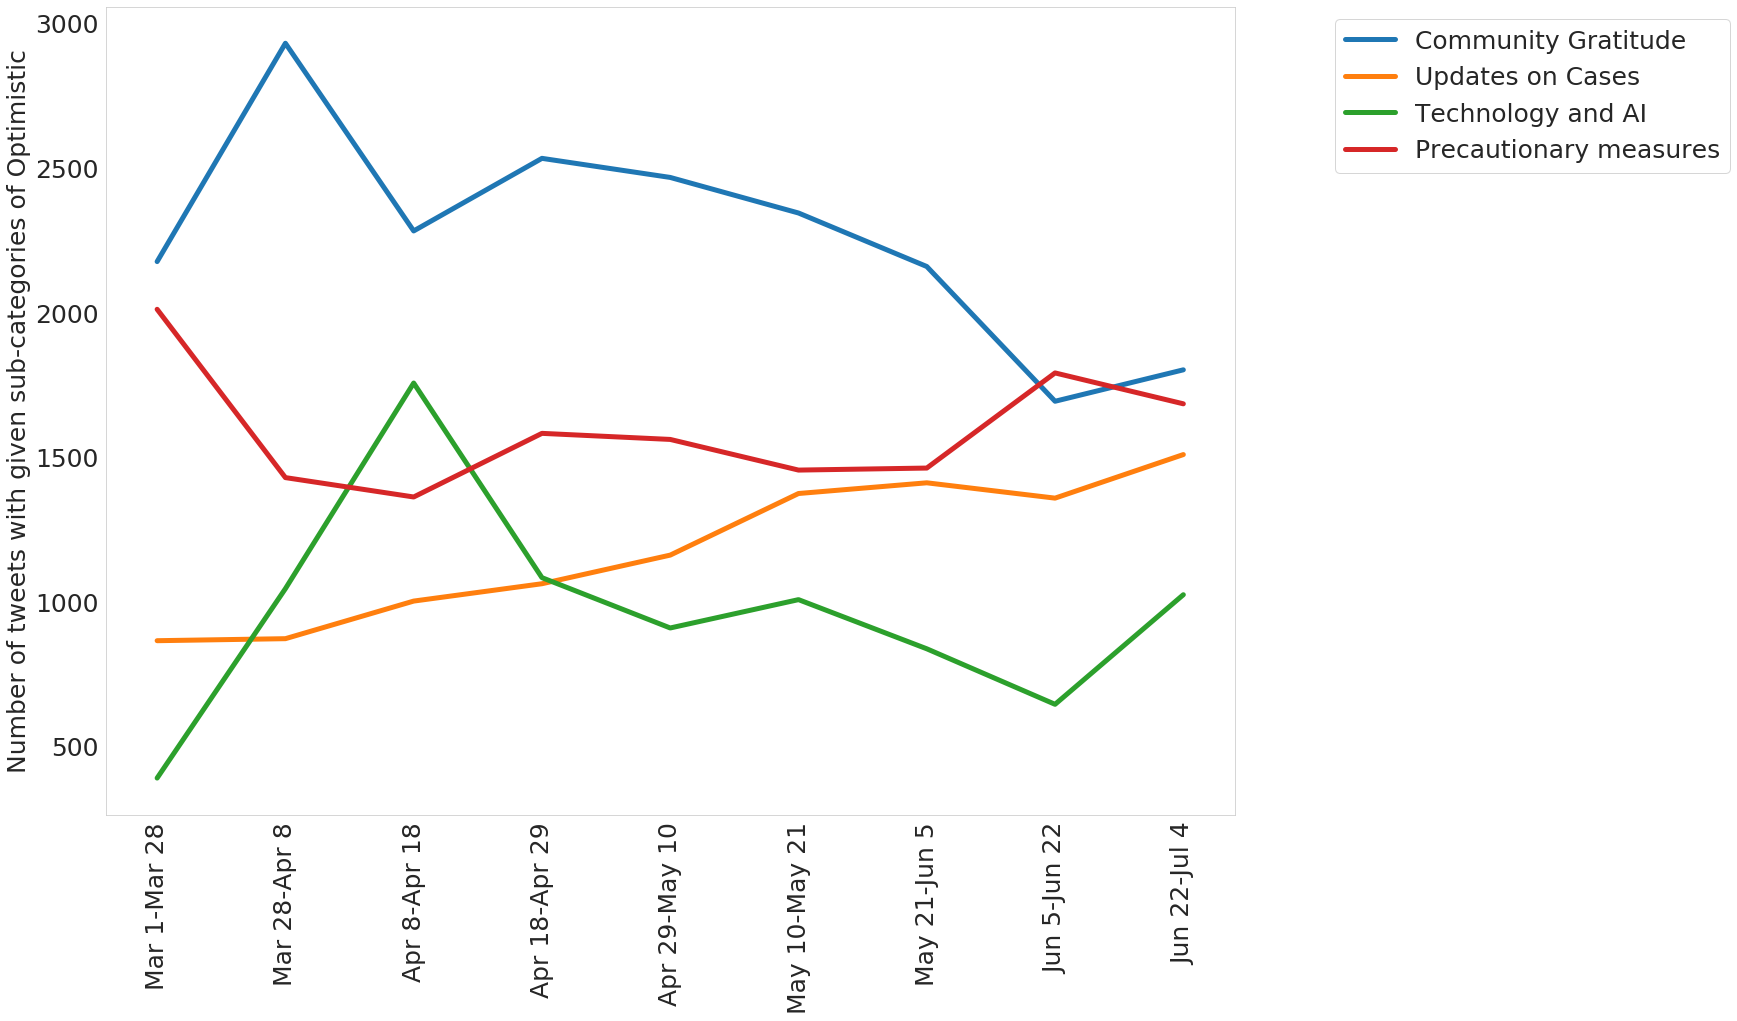

In [87]:
for aspect in aspects :
    # sns.set(font_scale=1.5)
    sns.set_style("whitegrid", {'axes.grid' : False})
    plt.rcParams["figure.figsize"] = (25.3,14.29)
    labels = [str(day_to_date(list(chunk['day number'])[0])) + '-' + str(day_to_date(list(chunk['day number'])[-1])) for chunk in chunks] 
    x = [i for i in range(len(chunks))]
    plt.xticks(x, labels=labels, rotation=90, fontsize=font)
    plt.tight_layout()
    plt.axis('on')
    plt.plot(x, counts[aspect], label="\n".join(textwrap.wrap(aspect, legend_wrap)), linewidth=width)
    plt.yticks(fontsize=font)
    plt.legend(loc="upper right", fontsize=font, bbox_to_anchor=(1.45,1))
#     plt.xlabel(xlbl, labelpad=xpad, fontsize=font)
    plt.ylabel(ylbl, fontsize=font)
#     for ax in plt.subplots():
#         ax.spines['bottom'].set_color('0.5')
#         ax.spines['top'].set_color('0.5')
#         ax.spines['right'].set_color('0.5')
#         ax.spines['left'].set_color('0.5')
#     plt.title(EMOTION, pad=tpad, fontsize=title_font, fontweight='bold')
# plt.show()
plt.savefig(f"plots/{EMOTION}_in_counts.png")
# import matplotlib2tikz
# matplotlib2tikz.save("")

In [54]:
# f = open('aspects/support_for_surprise.txt', "w")
# for k in aspects:
#     f.write(k+":\n")
#     for i, tup in enumerate(support[k]):
#         for sentence in support[k][i]:
#             f.write('range: '+sentence[0]+' ### word: '+sentence[1]+'\n')
# f.close()
support['Community Gratitude']

[[('Mar 1-Mar 28', 'solidarity'),
  ('Mar 1-Mar 28', 'healthcare'),
  ('Mar 1-Mar 28', 'across'),
  ('Mar 1-Mar 28', 'medical'),
  ('Mar 1-Mar 28', 'staff'),
  ('Mar 1-Mar 28', 'fund'),
  ('Mar 1-Mar 28', 'fighting'),
  ('Mar 1-Mar 28', 'services'),
  ('Mar 1-Mar 28', 'respect'),
  ('Mar 1-Mar 28', 'leadership'),
  ('Mar 1-Mar 28', 'leading'),
  ('Mar 1-Mar 28', 'front'),
  ('Mar 1-Mar 28', 'State'),
  ('Mar 1-Mar 28', 'society'),
  ('Mar 1-Mar 28', 'team'),
  ('Mar 1-Mar 28', 'globe'),
  ('Mar 1-Mar 28', 'State'),
  ('Mar 1-Mar 28', 'Doctors'),
  ('Mar 1-Mar 28', 'farmers'),
  ('Mar 1-Mar 28', 'brave'),
  ('Mar 1-Mar 28', 'solidarity'),
  ('Mar 1-Mar 28', 'committed'),
  ('Mar 1-Mar 28', 'Kudos'),
  ('Mar 1-Mar 28', 'nation'),
  ('Mar 1-Mar 28', 'leading'),
  ('Mar 1-Mar 28', 'front'),
  ('Mar 1-Mar 28', 'nations'),
  ('Mar 1-Mar 28', 'security'),
  ('Mar 1-Mar 28', 'personnel'),
  ('Mar 1-Mar 28', 'role'),
  ('Mar 1-Mar 28', 'commitment'),
  ('Mar 1-Mar 28', 'leadership'),
  ('Mar 1-

In [238]:
# dicts = {k:v for k,v in sorted(word_counts.items(), key=lambda x: x[1], reverse=True)}
# # print(dicts)
# for word in STOPWORDS :
#     if dicts.__contains__(word) or dicts.__contains__(word.lower()) :
# #         print(word)
#         pass